In [1]:
import preprocess
import tensorflow as tf
import numpy as np
from numpy import load
from numpy.random import randint

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import pyplot


In [2]:
# load and prepare training images
def load_real_samples():
    # load the face dataset
    data = load('img_align_celeba.npz')
    X = data['arr_0']
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    # load labels
    labels = load('img_align_celeba_labels.npz')
    Y = labels['arr_0']
    return X, Y

def generate_samples(dataset, labels, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    ix2 = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    X2 = dataset[ix2]
    Y = np.take(labels,ix)
    Y2 = np.take(labels,ix2)
    return X,X2, Y,Y2

class Model(tf.keras.Model):
    def __init__(self, latent_dim=200):
        super(Model, self).__init__()
        self.fc1 = Dense(1024, activation='elu')
        self.fc2 = Dense(latent_dim)
        self.optimizer = Adam(lr=0.001)
    def call(self, inputs):
        fc1 = self.fc1(tf.stop_gradient(inputs))
        fc2 = self.fc2(fc1)
        b = tf.math.reduce_mean(fc2,1)
        return b
    def loss(self, logits, labels):
        return tf.keras.losses.mean_squared_error(labels, logits)
    
def train(encoder,embeddings, dataset, labels, attrs, att, n_epochs=1000, n_batch=128):
    total_loss = []
#     attrs=tf.clip_by_value(attrs, 0, 1)
    for epoch in range(n_epochs):
        X1,X2,Y1,Y2 = generate_samples(dataset,labels,n_batch)
        inputs1 = []
        inputs2 = []
        for i in range(n_batch):
            emb1 = [embeddings[att[j]]*attrs[Y2[i]+1][j] for j in range(40)]
            inputs1.append(emb1)
            emb2 = [embeddings[att[j]]*attrs[Y1[i]+1][j] for j in range(40)]
            inputs2.append(emb2)
        image1 = encoder.predict(X1)
        image2 = encoder.predict(X2)
        with tf.GradientTape() as tape:
            outputs1=model.call(inputs1)
            outputs2=model.call(inputs2)
            outputs1 = (outputs1+tf.stop_gradient(image1))/2
            outputs2 = (outputs2+tf.stop_gradient(image2))/2
            loss=model.loss(outputs1,outputs2)
        total_loss.append(tf.math.reduce_sum(loss))
        print(np.mean(total_loss[len(total_loss)-50:]))
        gradients = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [3]:
encoder = load_model('encoder_model.h5')
generator = load_model('generator_model_100.h5')
embeddings = preprocess.load_embeddings("/git-repos/latent-space-arithmetic/dataset/embedding/glove.6B.100d.txt")

In [4]:
cats,attrs = preprocess.load_attributes("/git-repos/latent-space-arithmetic/dataset/Anno/list_attr_celeba.txt")


In [5]:
dataset, labels = load_real_samples()
labels = tf.constant([int(i[:len(i)-4])-1 for i in labels])

In [6]:
att = ['stubble',
 'arched',
 'attractive',
 'bags',
 'bald',
 'bangs',
 'lips',
 'nose',
 'black',
 'blond',
 'blurry',
 'brown',
 'bushy',
 'chubby',
 'chin',
 'eyeglasses',
 'goatee',
 'gray',
 'makeup',
 'cheekbones',
 'male',
 'open',
 'mustache',
 'narrow',
 'beard',
 'oval',
 'pale',
 'pointy',
 'receding',
 'rosy',
 'sideburns',
 'smiling',
 'straight',
 'wavy',
 'earrings',
 'hat',
 'lipstick',
 'necklace',
 'necktie',
 'young']

In [7]:
model = Model()

In [57]:
train(encoder,embeddings, dataset, labels, attrs, att)

22.385931
22.461376
22.973955
22.795647
22.782515
23.11518
22.960672
22.832596
22.846388
22.876547
22.815722
22.84559
22.857723
22.814837
22.82077
22.772583
22.80112
22.781895
22.814985
22.723976
22.780966
22.84274
22.865744
22.873423
22.865229
22.948473
22.936794
22.86682
22.950834
22.998577
23.042503
23.059868
23.06763
23.13889
23.181953
23.08669
23.053942
22.859741
22.910213
22.775885
22.830101
22.60231
22.510416
22.526766
22.496021
22.911102
23.035349
22.322292
21.983051
22.851921
22.862993
22.861204
22.84597
22.843328
22.868477
22.832863
22.874435
22.853338
22.870173
22.844257
22.863398
22.898157
22.908691
22.927849
22.930376
22.93458
22.929354
22.952175
22.93926
22.991344
22.986374
22.942654
22.936026
22.942493
22.966099
22.957388
22.932165
22.903637
22.893642
22.86007
22.842148
22.860971
22.84482
22.833992
22.882263
22.853155
22.87829
22.895212
22.85565
22.858686
22.856619
22.889135
22.894499
22.877817
22.879494
22.852472
22.874826
22.87528
22.912476
22.912434
22.915485
22.91204

KeyboardInterrupt: 

In [ ]:
model.save_weights('embedding_model_weights.ckpt')

In [65]:
vector = model.call(tf.constant([[embeddings['male']]]))


In [66]:
vector2 = model.call(tf.constant([[embeddings['lips']]]))

In [67]:
vector_image = (generator.predict(vector)+1)/2
vector2_image = (generator.predict(vector2)+1)/2

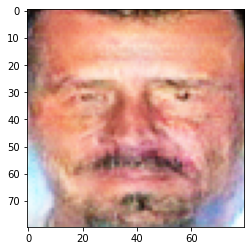

In [68]:
pyplot.imshow(vector_image[0])

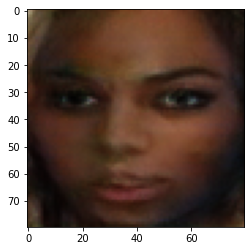

In [69]:
pyplot.imshow(vector2_image[0])

In [ ]:
a,b,c,d =generate_samples(dataset,labels,1)

In [ ]:
new_image = (a[0]+1)/2 + vector_image[0]*1.0
new_image = tf.clip_by_value(new_image, 0, 1)


In [ ]:
pyplot.imshow((b[0]+1)/2)

In [ ]:
predict = (encoder.predict(b)[0]*5 + vector*3)/8
ans = generator.predict(predict)

In [ ]:
pyplot.imshow((ans[0]+1)/2)